In [1]:
import time
from pathlib import Path
from operator import itemgetter

import scanpy as sc
import numpy as np
import pandas as pd
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from scipy.sparse import csr_matrix
from joblib import Parallel, delayed
import os
import torch

import scSLAT
from scSLAT.model import Cal_Spatial_Net, load_anndatas, run_SLAT_mlp_AGF, spatial_match, run_SLAT, compute_lisi_for_adata, run_SLAT_AGF_contrast
from scSLAT.viz import match_3D_multi, hist, Sankey, build_3D
from scSLAT.metrics import region_statistics


In [55]:
file_path_1 = os.path.join('D:/ppppaper/data/DLPFC/DLPFC/','151674')
adata_1 = sc.read_visium(path=file_path_1, count_file='filtered_feature_bc_matrix.h5', load_images=True)
adata_1.var_names_make_unique(join="++")

Ann_df_1 = pd.read_csv(os.path.join(file_path_1 , '151674_annotation.txt'),sep ='\t', header=0 , index_col=0)
Ann_df_1.loc[Ann_df_1['Layer'].isna(),'Layer'] = "unknown"
adata_1.obs['annotation'] = Ann_df_1.loc[adata_1.obs_names, 'Layer'].astype('category')

d:\Anaconda\envs\scSLAT\lib\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
d:\Anaconda\envs\scSLAT\lib\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [56]:
file_path_2 = os.path.join('D:/ppppaper/data/DLPFC/DLPFC/','151675')
adata_2 = sc.read_visium(path=file_path_2, count_file='filtered_feature_bc_matrix.h5', load_images=True)
adata_2.var_names_make_unique(join="++")

Ann_df_2 = pd.read_csv(os.path.join(file_path_2 , '151675_annotation.txt'),sep ='\t', header=0 , index_col=0)
Ann_df_2.loc[Ann_df_2['Layer'].isna(),'Layer'] = "unknown"
adata_2.obs['annotation'] = Ann_df_2.loc[adata_2.obs_names, 'Layer'].astype('category')

d:\Anaconda\envs\scSLAT\lib\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
d:\Anaconda\envs\scSLAT\lib\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [57]:
# adata_1=sc.read_h5ad('D:\ppppaper\data\BARISTAseq\Slice_2.h5ad')
# adata_1.var_names_make_unique(join="++")
# adata_2=sc.read_h5ad('D:\ppppaper\data\BARISTAseq\Slice_3.h5ad')
# adata_2.var_names_make_unique(join="++")

In [58]:
# adata_1=sc.read_h5ad(r'D:\ppppaper\data\STARmap\20180419_BZ9_control.h5ad')
# adata_1.var_names_make_unique(join="++")
# adata_2=sc.read_h5ad(r'D:\ppppaper\data\STARmap\20180417_BZ5_control.h5ad')
# adata_2.var_names_make_unique(join="++")

In [59]:
# adata_1=sc.read_h5ad('D:\ppppaper\data\MERFISH\MERFISH_0.14.h5ad')
# adata_1.var_names_make_unique(join="++")
# adata_1.obs['annotation'] = adata_1.obs['ground_truth']
# adata_2=sc.read_h5ad('D:\ppppaper\data\MERFISH\MERFISH_0.19.h5ad')
# adata_2.var_names_make_unique(join="++")
# adata_2.obs['annotation'] = adata_2.obs['ground_truth']

In [60]:
x1_coords=adata_1.obsm['spatial'][:,0]
y1_coords=adata_1.obsm['spatial'][:,1]
x2_coords=adata_2.obsm['spatial'][:,0]
y2_coords=adata_2.obsm['spatial'][:,1]
locations_1 = np.array([x1_coords, y1_coords])
locations_2 = np.array([x2_coords, y2_coords])

locations_1_tensor = torch.tensor(locations_1)
locations_2_tensor = torch.tensor(locations_2)
locations_1_tensor = locations_1_tensor.transpose(0, 1)
locations_1_tensor = locations_1_tensor.to(dtype=torch.float32)
locations_2_tensor = locations_2_tensor.transpose(0, 1)
locations_2_tensor = locations_2_tensor.to(dtype=torch.float32)
location = [locations_1_tensor, locations_2_tensor]

In [61]:
Cal_Spatial_Net(adata_1, k_cutoff=10, model='KNN')
Cal_Spatial_Net(adata_2, k_cutoff=10, model='KNN')

Calculating spatial neighbor graph ...
The graph contains 38433 edges, 3673 cells.
10.463653689082493 neighbors per cell on average.
Calculating spatial neighbor graph ...
The graph contains 37544 edges, 3592 cells.
10.452115812917596 neighbors per cell on average.


In [62]:
edges, features = load_anndatas([adata_1, adata_2], feature='DPCA')

Use DPCA feature to format graph


d:\Anaconda\envs\scSLAT\lib\site-packages\anndata\_core\anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\preprocessing\_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [79]:
features[1].shape

torch.Size([3592, 50])

In [63]:
embd0, embd1, norm0, norm1, time = run_SLAT(features, edges)

GPU is not available
Running
---------- epochs: 1 ----------
---------- epochs: 2 ----------
---------- epochs: 3 ----------
---------- epochs: 4 ----------
---------- epochs: 5 ----------
---------- epochs: 6 ----------
Training model time: 37.88


In [64]:
norm0

tensor([0.0953, 0.0953, 0.0953,  ..., 0.1000, 0.0667, 0.1000])

In [65]:
norm1

tensor([0.0877, 0.1000, 0.1000,  ..., 0.1000, 0.0909, 0.0909])

In [66]:
pathology_color = [
    "#1F77B4", "#FF7F0E", "#2CA02C", "#D62728", "#9467BD", "#8C564B",
    "#E377C2", "#7F7F7F", "#BCBD22", "#17BECF", "#AEC7E8", "#FFBB78",
    "#98DF8A", "#FF9896", "#C5B0D5", "#C49C94", "#F7B6D2", "#C7C7C7",
    "#DBDB8D", "#9EDAE5", "#1F9B99", "#FFCD56", "#33A02C", "#FB9A99",
    "#A6CEE3"
]

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch

def plot_norm_distribution(norm):
    # 确保 norm 是一维张量
    if isinstance(norm, torch.Tensor):
        norm = norm.numpy()
    
    plt.figure(figsize=(10, 4))
    sns.histplot(norm, kde=False, bins=20, color="#E7A9C5", alpha=0.7)
    plt.xlabel("", fontsize=28)
    plt.ylabel("", fontsize=28)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.grid(alpha=0.3)
    plt.show()

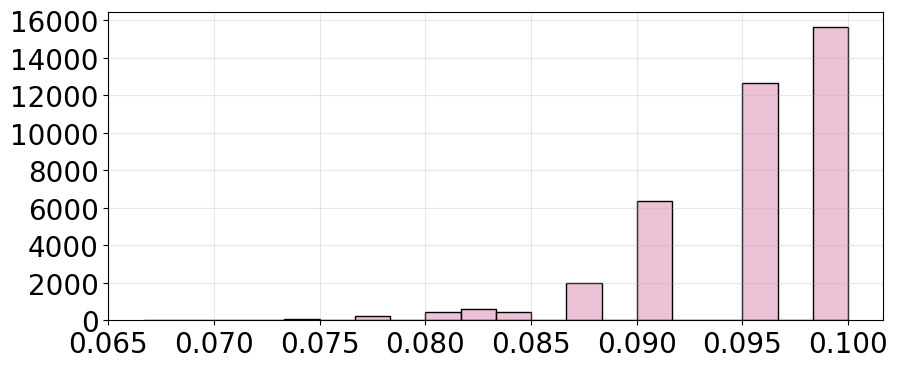

In [68]:
plot_norm_distribution(norm0)

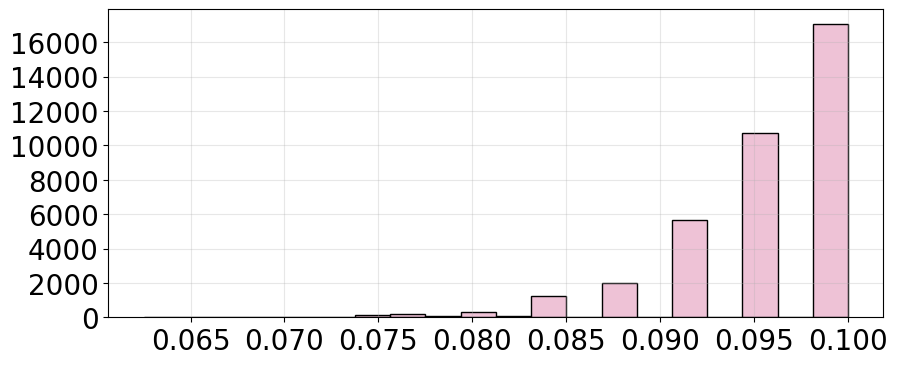

In [69]:
plot_norm_distribution(norm1)

In [70]:
# embd0_0, embd0_1, embd1_0, embd1_1, embd0, embd1, time = run_SLAT_AGF_contrast(features, edges, location, limit_loss=0.0001)

In [71]:

from scSLAT.model.utils import stLVG_contrast_norm


embd0_0, embd0_1, norm2, norm3, embd1_0, embd1_1, norm4, norm5, time = stLVG_contrast_norm(features, edges, location)

GPU is not available
Running
---------- epochs: 1 ----------
---- Ran row_normalize in 0.02 s ----

---- Ran row_normalize in 0.03 s ----

---------- epochs: 2 ----------
---- Ran row_normalize in 0.03 s ----

---- Ran row_normalize in 0.03 s ----

---------- epochs: 3 ----------
---- Ran row_normalize in 0.04 s ----

---- Ran row_normalize in 0.03 s ----

---------- epochs: 4 ----------
---- Ran row_normalize in 0.03 s ----

---- Ran row_normalize in 0.03 s ----

---------- epochs: 5 ----------
---- Ran row_normalize in 0.03 s ----

---- Ran row_normalize in 0.03 s ----

---------- epochs: 6 ----------
---- Ran row_normalize in 0.03 s ----

---- Ran row_normalize in 0.04 s ----

---- Ran row_normalize in 0.04 s ----

---- Ran row_normalize in 0.04 s ----

---------- epochs: 1 ----------
---- Ran row_normalize in 0.03 s ----

---- Ran row_normalize in 0.03 s ----

---------- epochs: 2 ----------
---- Ran row_normalize in 0.04 s ----

---- Ran row_normalize in 0.04 s ----

---------- ep

In [72]:
norm2

tensor([0.0768, 0.0779, 0.1340,  ..., 0.0000, 0.0000, 0.0000])

In [73]:
norm3

tensor([0.1165, 0.0674, 0.0675,  ..., 0.0000, 0.0000, 0.0000])

In [74]:
def plot_norm_distribution(norm):
    # 确保 norm 是一维张量
    if isinstance(norm, torch.Tensor):
        norm = norm.numpy()
    
    plt.figure(figsize=(10, 4))
    sns.histplot(norm, kde=False, bins=20, color="#F4806E", alpha=0.7)
    plt.xlabel("", fontsize=28)
    plt.ylabel("", fontsize=28)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.grid(alpha=0.3)
    plt.show()


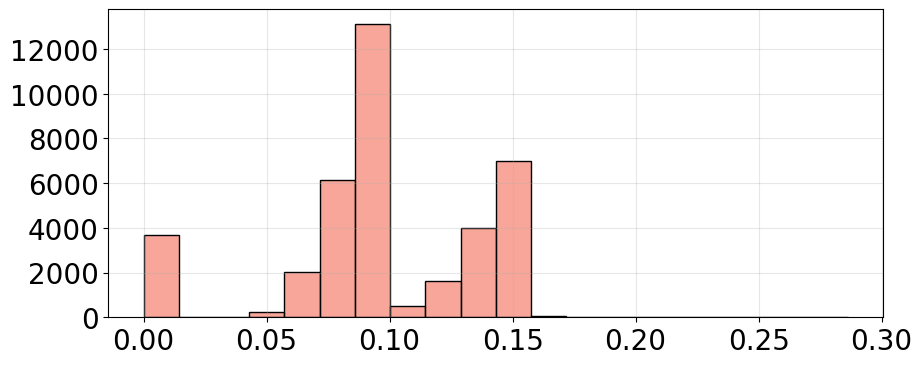

In [75]:
plot_norm_distribution(norm2)

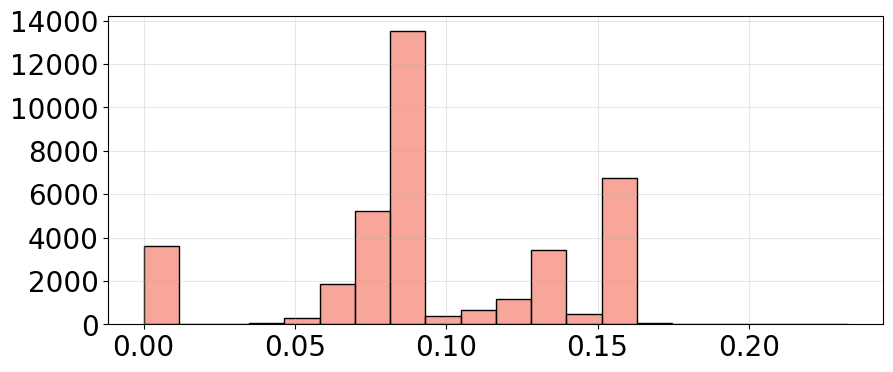

In [76]:
plot_norm_distribution(norm3)